<a href="https://colab.research.google.com/github/Hitesh1912/Mercari-Price-Suggestion-Challenge/blob/master/Copy_of_RNN_model_DMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Pre-requisite to install before running the code

If you are installing any dependent libraries, please specify here as pre-req 
to install before running the notebook


1.   scikit-learn
2.   Keras


In [2]:
#run to install pre-req libraries
!pip install textstat


     |████████████████████████████████| 3.0MB 15.0MB/s 


In [134]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.21.3)


In [3]:
from datetime import datetime 
start_real = datetime.now()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydot_ng as pydot
from textstat import textstat
import dask.dataframe as dd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dropout, Dense, concatenate, GRU, Embedding, Flatten, Activation
from keras.optimizers import Adam
from keras.models import Model
from keras.utils import plot_model
from keras import backend as K
from nltk.corpus import stopwords
import math
# set seed
np.random.seed(123)

Using TensorFlow backend.


### Store the dataset

In [5]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("/content/gdrive/My Drive/DMT/mercari-price-suggestion-challenge"))
input_folder = '/content/gdrive/My Drive/DMT/mercari-price-suggestion-challenge/'

# Any results you write to the current directory are saved as output.

['train.tsv', 'test.tsv', 'train.pkl', 'results.csv', 'model.png', 'full_df.pkl', 'train_data.pkl', 'tok_test_data.pkl', 'tok_train_data.pkl']


## 1. Loading Data

In [199]:
train_data = pd.read_csv(input_folder + 'train.tsv', sep='\t')
print("train shape",np.shape(train_data))
train_data.head()

train shape (1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [32]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [0]:
train_data.describe()

,train_id,item_condition_id,price,shipping,desc_len,name_len,target
count,1.481658e+06,1.481658e+06,1.481658e+06,1.481658e+06,1.481658e+06,1.481658e+06,1.481658e+06
mean,7.412429e+05,1.907323e+00,2.674928e+01,4.473266e-01,2.551959e+01,4.400937e+00,2.980807e+00
std,4.279713e+05,9.031762e-01,3.848908e+01,4.972179e-01,3.051796e+01,1.654781e+00,7.458991e-01
min,0.000000e+00,1.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.386294e+00
25%,3.705872e+05,1.000000e+00,1.000000e+01,0.000000e+00,7.000000e+00,3.000000e+00,2.397895e+00
50%,7.412365e+05,2.000000e+00,1.700000e+01,0.000000e+00,1.500000e+01,4.000000e+00,2.890372e+00
75%,1.111876e+06,3.000000e+00,2.900000e+01,1.000000e+00,3.100000e+01,6.000000e+00,3.401197e+00
max,1.482534e+06,5.000000e+00,2.000000e+03,1.000000e+00,2.450000e+02,1.700000e+01,7.601402e+00


In [0]:
train_data.price.describe().apply(lambda x: format(x, 'f'))

count    1481658.000000
mean          26.749280
std           38.489080
min            3.000000
25%           10.000000
50%           17.000000
75%           29.000000
max         2000.000000
Name: price, dtype: object

## 2. Exploratory Data Analysis

In [0]:
#FOR THE PURPOSE OF EDA

def fill_missing_data(data):
    data.category_name.fillna(value = "unk_cat1/unk_cat2/unk_cat3", inplace = True)
    if hasattr(data, 'brand_name'):
      data.brand_name.fillna(value = "unk_brand", inplace = True)   #comment this line if combining with name
    data.item_description.fillna(value = "unk_description", inplace = True)
    return data
#keeping copy of original data
train_data_copy = train_data.copy()

In [0]:
train_data_copy = fill_missing_data(train_data_copy)
# TODO Delete later, just used for verification
train_data_copy.nunique()

train_id             1481658
name                 1224593
item_condition_id          5
category_name           1288
brand_name            125963
price                    824
shipping                   2
item_description     1280669
desc_len                 229
name_len                  15
subcat_0                  11
subcat_1                 114
subcat_2                 871
target                   824
dtype: int64

In [0]:
# TODO Delete later, just used for verification
train_data_copy.isnull().any()

train_id             False
name                 False
item_condition_id    False
category_name        False
brand_name           False
price                False
shipping             False
item_description     False
desc_len             False
name_len             False
subcat_0             False
subcat_1             False
subcat_2             False
target               False
dtype: bool

In [0]:
train_data_copy = pd.concat([train_data_copy, train_data_copy.category_name.str.split('/', n = 2, expand=True).rename({0: 'cat_1', 1: 'cat_2', 2: 'cat_3'}, axis=1)], axis=1)
train_data_copy.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,desc_len,name_len,subcat_0,subcat_1,subcat_2,target,cat_1,cat_2,cat_3
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,MLB Cincinnati Reds T Shirt Size XL,10.0,1,No description yet,0,7,Men,Tops,T-shirts,2.397895,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,36,4,Electronics,Computers & Tablets,Components & Parts,3.970292,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,29,2,Women,Tops & Blouses,Blouse,2.397895,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,32,3,Home,Home Décor,Home Décor Accents,3.583519,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,44.0,0,Complete with certificate of authenticity,5,4,Women,Jewelry,Necklaces,3.806662,Women,Jewelry,Necklaces


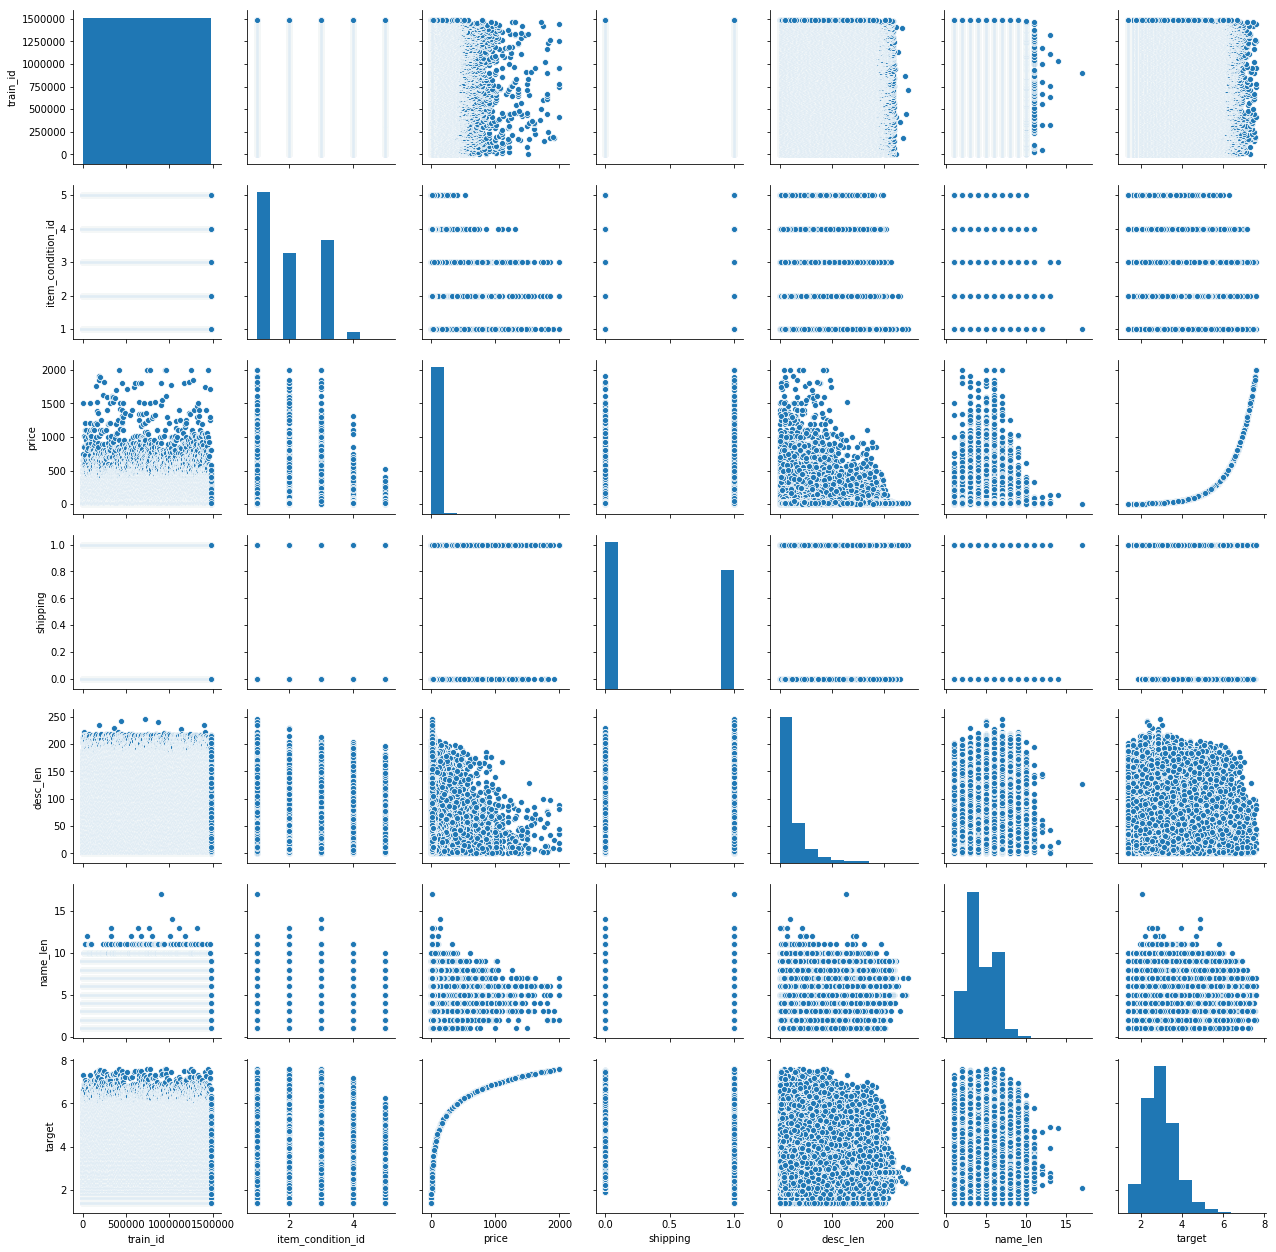

In [0]:
%%time
# Overall graph comparasin of all the features against each other
import seaborn as sns
sns.pairplot(train_data_copy)

### List of Categories to which a product belongs in the dataset




In [0]:
train_data_copy.cat_1.unique()

array(['Men', 'Electronics', 'Women', 'Home', 'Sports & Outdoors',
       'Vintage & Collectibles', 'Beauty', 'Other', 'Kids', 'unk_cat1',
       'Handmade'], dtype=object)

There are 11 Main Categories in the dataset 


*   Men
*   Electronics
*   Women
*   Home
*   Sports & Outdoors
*   Vintage & Collectibles
*   Beauty
*   Other
*   HandMade
*   Women
*   Unspecified Category




### Price Distribution in the Dataset

In [0]:
train_data_copy.price.describe().apply(lambda x: format(x, 'f'))

count    1481658.000000
mean          26.749280
std           38.489080
min            3.000000
25%           10.000000
50%           17.000000
75%           29.000000
max         2000.000000
Name: price, dtype: object

The Price range in the data set starts from 0 to 2009 with the overall averge price the dataset being 26.7

Text(-0.08, 0.5, 'train_id')

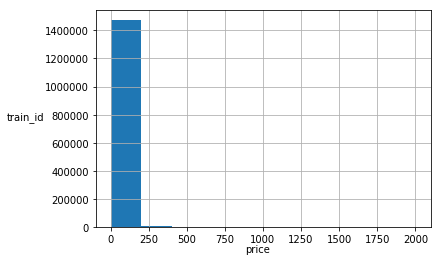

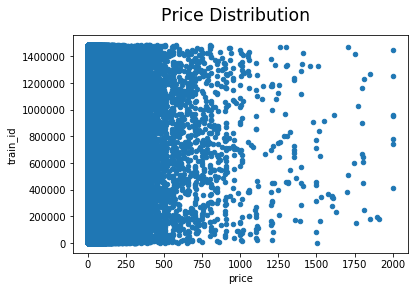

In [0]:
# Visualising the price distribution using graphs 
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
train_data_copy.price.hist()
train_data_copy.plot.scatter(x='price',y='train_id')
plt.suptitle('Price Distribution', ha='center', fontsize='xx-large')
fig.text(0.5, 0.04, 'price', ha='center')
fig.text(-0.08, 0.5, 'train_id')

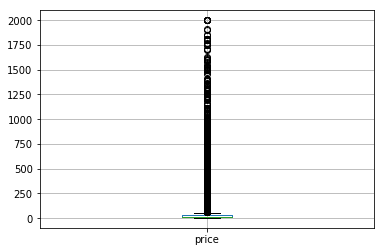

In [0]:
train_data_copy.boxplot(column=['price'])

Majority of the products sell within the 225 dollar scatter plot gives more observable distribution of price in dataset

### Brand Name and Price

In [0]:
# Over 4000 unique brands in the dataset
print("Unique Brands in Data Set :" +  str(train_data_copy.brand_name.unique().size))
print(train_data_copy.brand_name.describe())

Unique Brands in Data Set :125963
count     1481658
unique     125963
top       missing
freq       494994
Name: brand_name, dtype: object


In [0]:
# Most popular brands with most items for sale in dataset
brand_info = train_data_copy["brand_name"].value_counts()
bf = pd.DataFrame(brand_info).reset_index()
bf.columns = ['Brand Name', 'count']
bf[1:10]

,Brand Name,count
1,PINK,54053
2,Nike,53943
3,Victoria's Secret,48041
4,LuLaRoe,31070
5,Apple,17304
6,FOREVER 21,15173
7,Nintendo,14999
8,Lululemon,14569
9,Michael Kors,13939


Text(0, 0.5, 'Avg Selling Price in $')

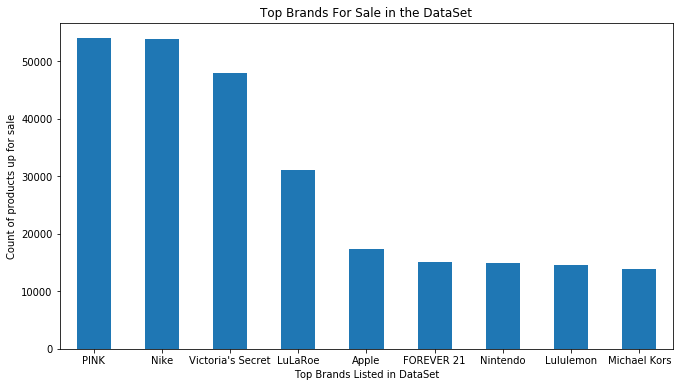

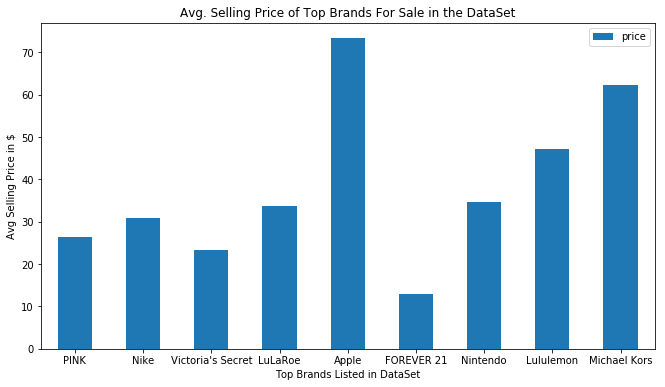

In [0]:
# Plotting a graph for count plot of popular brand and avg selling price of these brands

# Count Plot
ax = brand_info[1:10].plot.bar(y="count" , rot=0,figsize=(11, 6), title="Top Brands For Sale in the DataSet")
ax.set_xlabel("Top Brands Listed in DataSet")
ax.set_ylabel("Count of products up for sale")

# Popular Brand average Selling Price
bi = train_data_copy.pivot_table('price', index='brand_name', aggfunc='mean')
brand_info[1:10].tolist()
tb = bi.loc[bf[1:10]['Brand Name']]
ax = tb.plot.bar(y='price', rot=0,figsize=(11, 6),title="Avg. Selling Price of Top Brands For Sale in the DataSet")
ax.set_xlabel("Top Brands Listed in DataSet")
ax.set_ylabel("Avg Selling Price in $")

By Observing the graph for Count plot and Avg Selling Price for top brands we can see that


*   Clothing brands like PINK, Nike, Victoria's Secret etc. have the most products on sale. and since cloths don't cost as muc has electronics or luxury items their product count is high but average selling price is low
*   Electronic brands like Apple, Nintendo have lower product count as compared to clothing brands but have a higher average selling price, this makes sense as electronics products are more expensive then clothing
*  Micheal Kors which is luxury brand, has lower products on sale in the dataset but has a high avg. selling price since luxury brands have a higher selling price



In [0]:
bi = train_data_copy.pivot_table('price', index='brand_name', aggfunc='mean')

# Listing brands which have the higest average selling price for a product

bi.sort_values(by=['price'],ascending=False).head()

,price
brand_name,
Vs2/I 1ct Diamond Engagement Ring,2000.0
Chanel J12 H0682 Wrist Watch for Women,1999.0
14kt 14k Gold Diamond Ring PLUS,1800.0
Chanel Purse Reserved.,1750.0
IPad Air Pro,1400.0


Text(0, 0.5, 'Avg Selling Price in $')

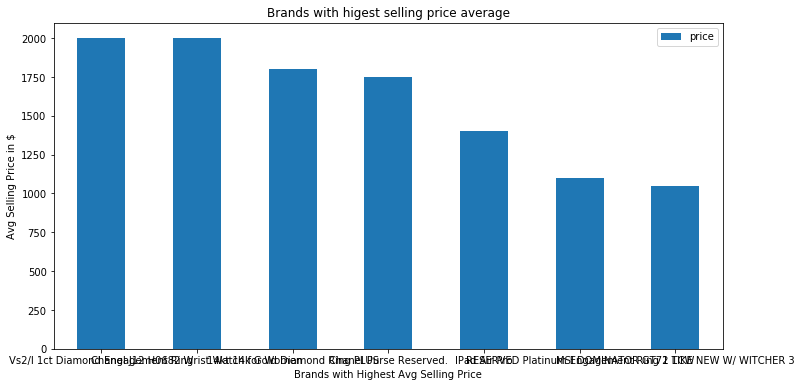

In [0]:
# Plotting graph comparing selling price of products to the most listed (popular) brand in the dataset
ax = bi.sort_values(by=['price'],ascending=False)[0:7].plot.bar(y='price', rot=0,figsize=(12, 6),title="Brands with higest selling price average")
ax.set_xlabel("Brands with Highest Avg Selling Price")
ax.set_ylabel("Avg Selling Price in $")


#BUG



*   Brands like Demdaco (exclusive range of artist-driven gifts), Proenza Schouler (designer brand) naturally have higher selleing price since they are part of luxury brand and correspondingly their count of products for sale is also less oweing to high price and affodability.





### Main Category and Price 


In [0]:
# Most popular brands with most items for sale in dataset
category_info = train_data_copy["cat_1"].value_counts()
df = pd.DataFrame(category_info).reset_index()
df.columns = ['Category Name', 'count']
df[1:10]

,Category Name,count
1,Beauty,207725
2,Kids,171555
3,Electronics,122632
4,Men,93609
5,Home,67831
6,Vintage & Collectibles,46519
7,Other,45329
8,Handmade,30835
9,Sports & Outdoors,25322


ValueError: ignored

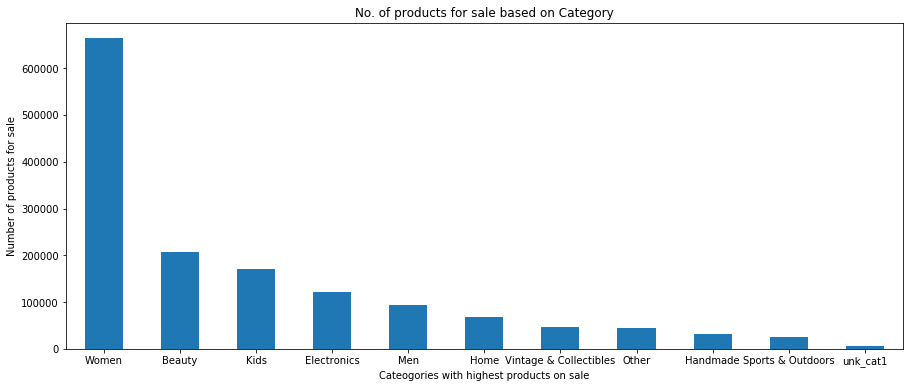

In [0]:
# Count plot of Category Names and their a plot of their average selling price

# Count Plot
ax = category_info.plot.bar(rot=0,figsize=(15, 6),title="No. of products for sale based on Category")
ax.set_xlabel("Cateogories with highest products on sale")
ax.set_ylabel("Number of products for sale")

# Average Selling Price
cat_data = pd.concat([train_data_copy, train_data_copy.category_name.str.split('/', n = 2, expand=True).rename({0: 'cat_1', 1: 'cat_2', 2: 'cat_3'}, axis=1)], axis=1)
ci = cat_data.pivot_table('price', index='cat_1', aggfunc='mean')
ci.plot.bar(y='price', rot=0,figsize=(15, 6),title=" Avg. selling price based off category types")
ax.set_xlabel("Cateogories with highest products on sale")
ax.set_ylabel("AVerage Selling Price")


From the Count plot and Avg selling price graph plot for Main category from data set it can be observed that
*   Clothing/Shoe/Bags etc. have the highest no. of products on sale (Women, Beauty,Kids,Men) Vategoty. 
*   Categories such as Electronics, Sports and Vintage and Collectibles have lower products on sale but have higher sellnig price as naturally Vintage and Electronics tend to cost more than clothing



### Shipping and Price 

Text(-0.08, 0.5, 'Products')

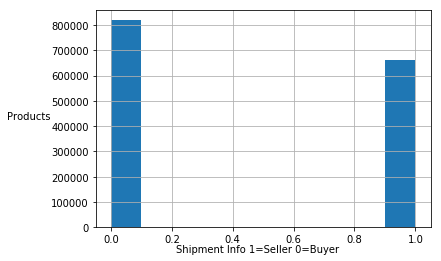

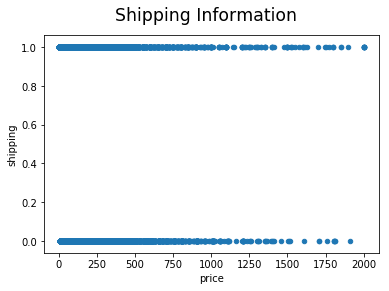

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)

train_data_copy.shipping.hist()
train_data_copy.plot.scatter(x='price',y='shipping')

# Visualising the shipping distribution using graphs 
plt.suptitle('Shipping Information', ha='center', fontsize='xx-large')
fig.text(0.5, 0.04, 'Shipment Info 1=Seller 0=Buyer', ha='center')
fig.text(-0.08, 0.5, 'Products')

From the above graph it can be observed that 


*   There are more items for which the buyer has to pay for shipping (shipping =0) vs compared to when seller pays for the shipping (shipping =1)
*   Avg. Selling price seems to be uniform between the two methods of shipment.



### WORD CLOUD

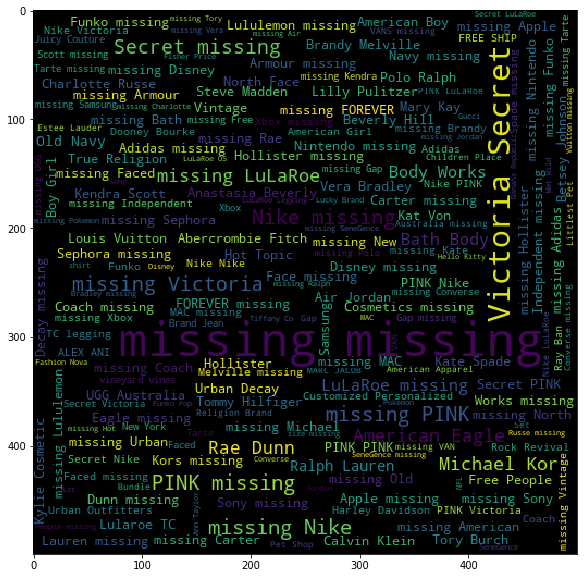

In [0]:
#!pip install wordcloud
from wordcloud import WordCloud
import os
wordcloud = WordCloud(width = 500, height = 500).generate(" ".join(train_data_copy.brand_name.astype(str)))
plt.figure(figsize = (15, 10))
plt.imshow(wordcloud)
plt.show()

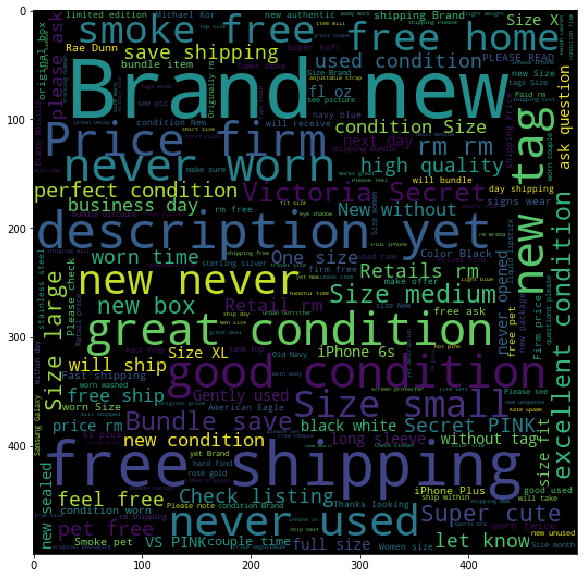

In [0]:
from wordcloud import WordCloud
import os

wordcloud = WordCloud(width = 500, height = 500).generate(" ".join(train_data_copy.item_description.astype(str)))
plt.figure(figsize = (15, 10))
plt.imshow(wordcloud)
plt.show()

### Use Linear Regression and HeatMap for Feature Correlation : Analysis the correlation between Dependent variable (Price) and independent variables

In [0]:
# Function to convert string to numeric value (Can be useful for regression Model)
def toNumeric(data,to):
    if train_data[data].dtype == type(object):
        le = preprocessing.LabelEncoder()
        train_data[to] = le.fit_transform(train_data[data].astype(str)) 

In [0]:
toNumeric('name','num_name')
toNumeric('category_name','num_category_name')
toNumeric('cat_1','num_cat_1')
toNumeric('cat_2','num_cat_2')
toNumeric('cat_3','num_cat_3')
train_data.head()

,train_id,name,category_name,price,shipping,item_description,item_condition_id_1,item_condition_id_2,item_condition_id_3,item_condition_id_4,item_condition_id_5,cat_1,cat_2,cat_3,item_description_readability_score,num_name,num_category_name,num_cat_1,num_cat_2,num_cat_3
0,0,MLB Cincinnati Reds T Shirt Size XL,Men/Tops/T-shirts,-0.433771,1,No description yet,0,0,1,0,0,Men,Tops,T-shirts,14.53,662852,808,5,102,762
1,1,Razer BlackWidow Chroma Keyboard Razer,Electronics/Computers & Tablets/Components & P...,0.654705,0,This keyboard is in great condition and works ...,0,0,1,0,0,Electronics,Computers & Tablets,Components & Parts,8.13,933447,86,1,30,212
2,2,AVA-VIV Blouse Target,Women/Tops & Blouses/Blouse,-0.433771,1,Adorable top with a hint of lace and a key hol...,1,0,0,0,0,Women,Tops & Blouses,Blouse,5.80,92350,1254,9,103,94
3,3,Leather Horse Statues,Home/Home Décor/Home Décor Accents,0.214131,1,New with tags. Leather horses. Retail for [rm]...,1,0,0,0,0,Home,Home Décor,Home Décor Accents,2.12,579797,485,3,55,404
4,4,24K GOLD plated rose,Women/Jewelry/Necklaces,0.447376,0,Complete with certificate of authenticity,1,0,0,0,0,Women,Jewelry,Necklaces,18.00,45793,1181,9,58,536


Text(0.5, 0.98, ' Correlations Heat Map for attributes')

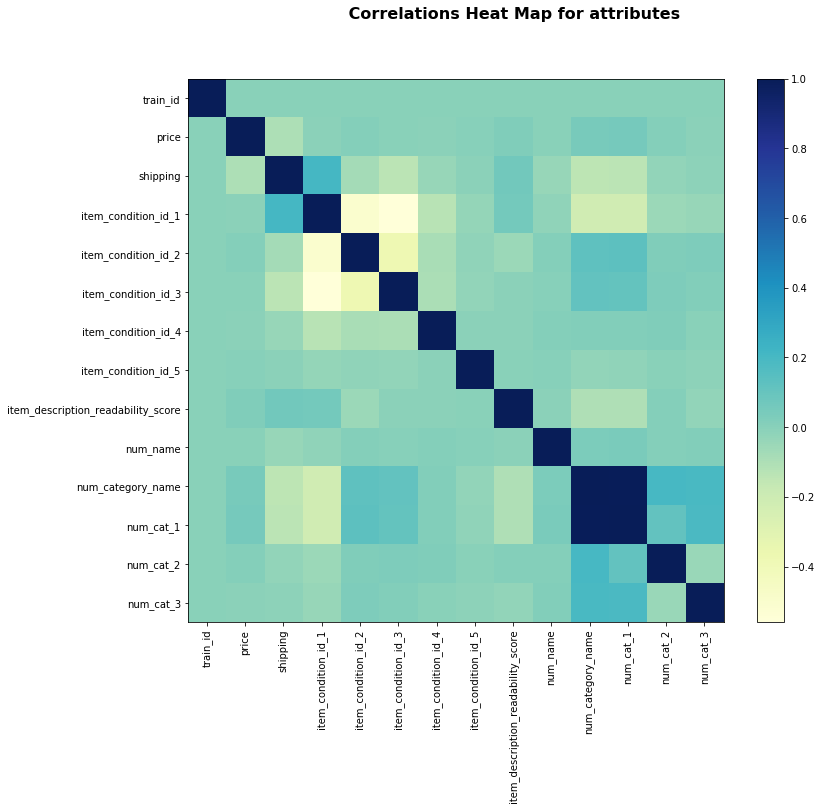

In [0]:
corltn=train_data.corr()
corltn=corltn.fillna(0)
plt.figure(figsize=(12, 10))
plt.imshow(corltn, cmap='YlGnBu', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corltn)), corltn.columns, rotation='vertical')
plt.yticks(range(len(corltn)), corltn.columns);
plt.suptitle(' Correlations Heat Map for attributes', fontsize=16, fontweight='bold')

In [0]:
cats = train_data['cat_1'].value_counts().index.values.astype('str')
cats

array(['Women', 'Beauty', 'Kids', 'Electronics', 'Men', 'Home',
       'Vintage & Collectibles', 'Other', 'Handmade', 'Sports & Outdoors',
       'unk_cat1'], dtype='<U22')

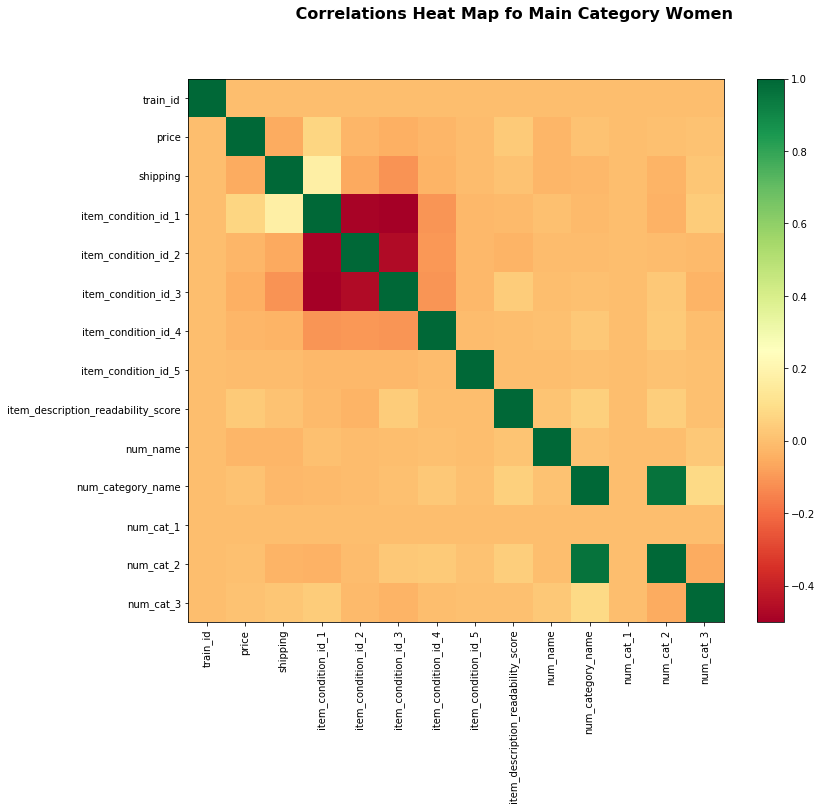

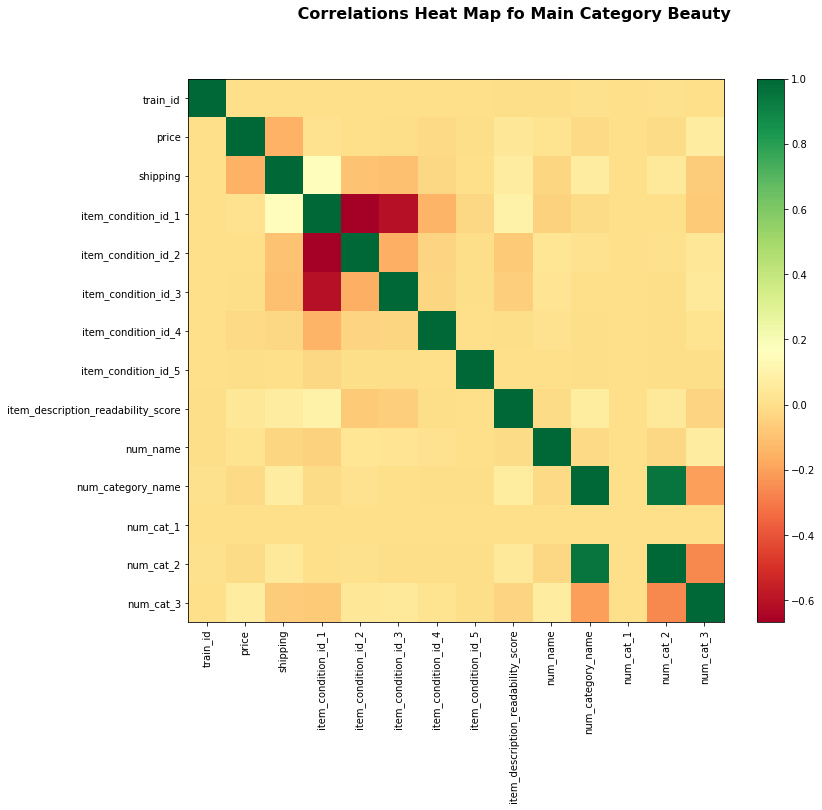

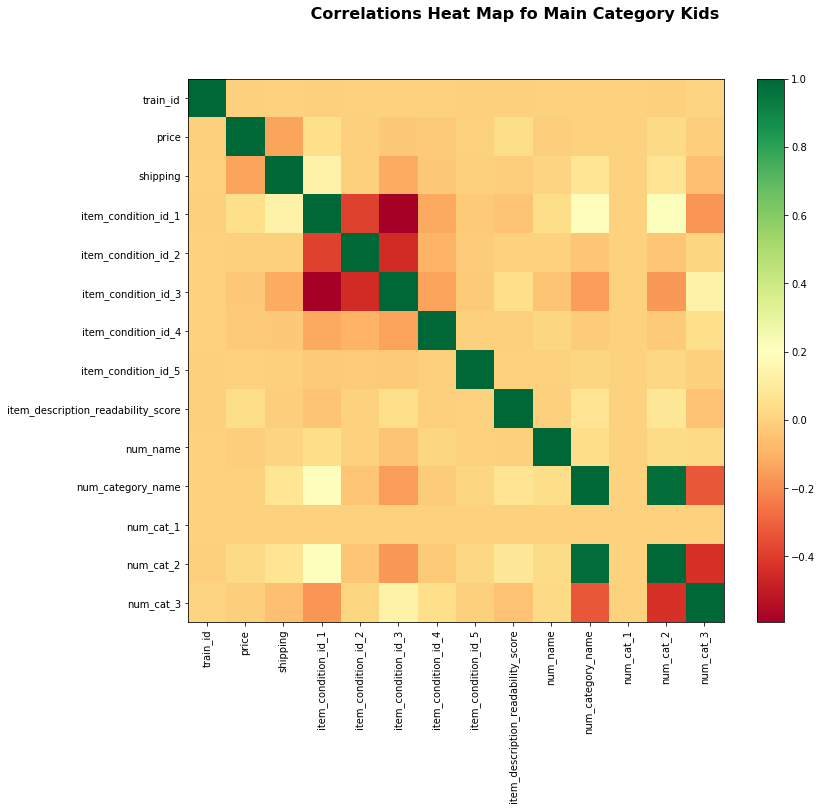

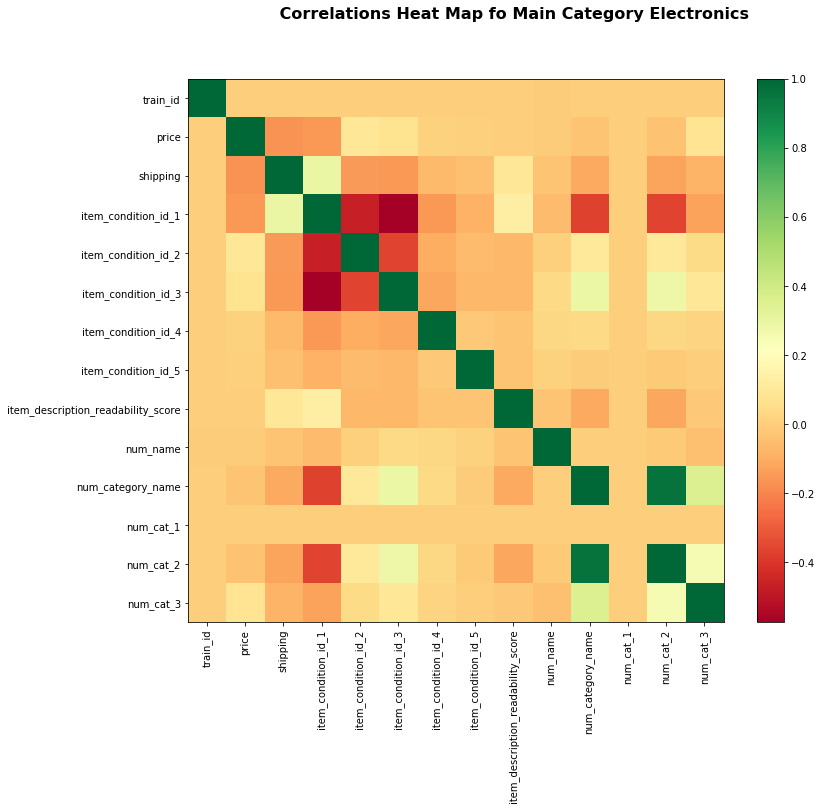

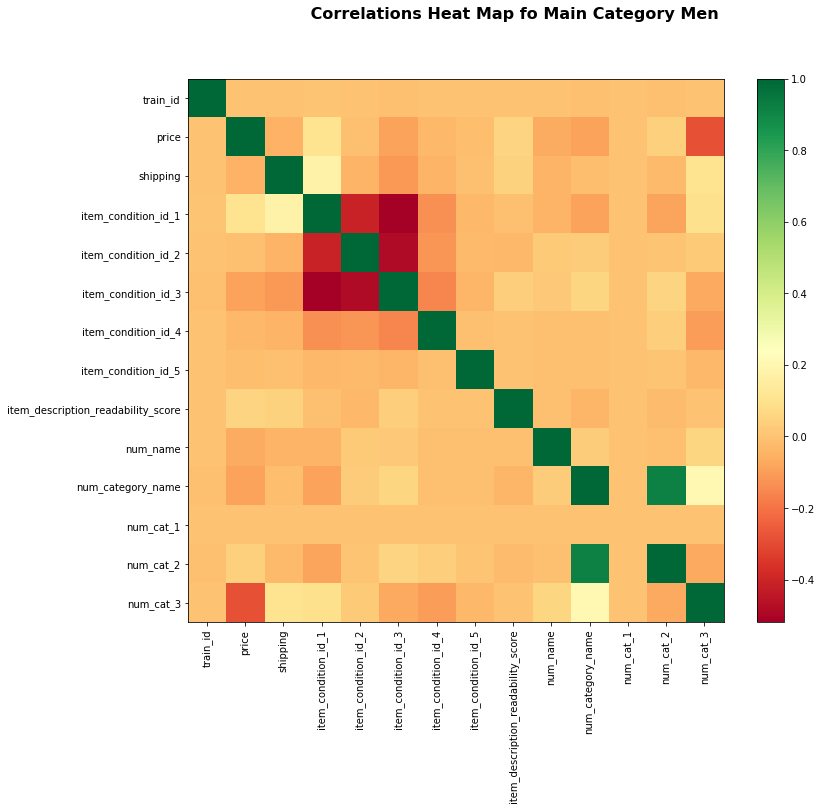

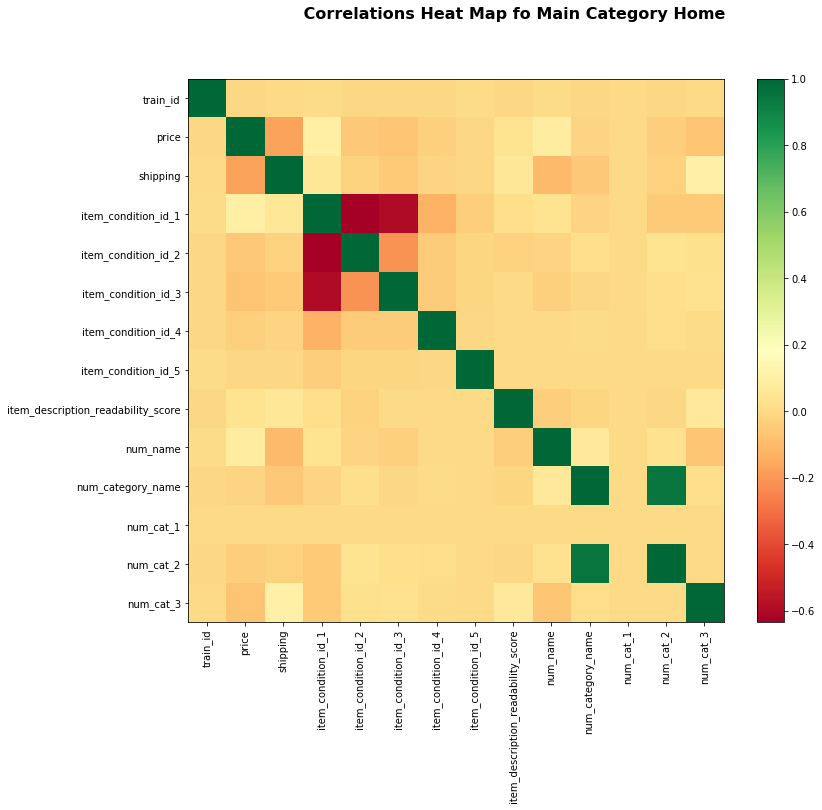

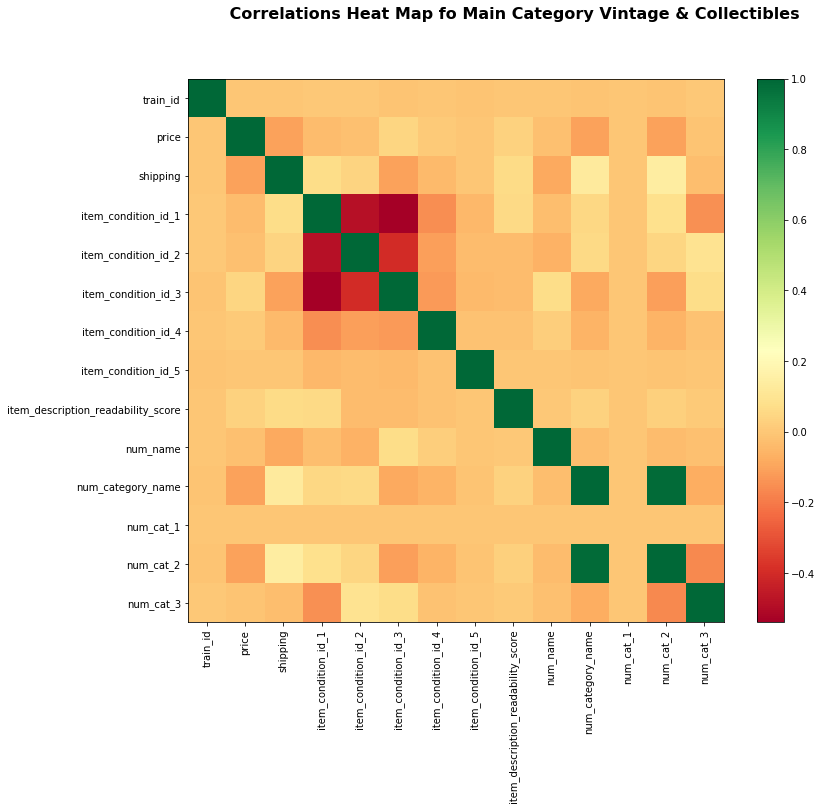

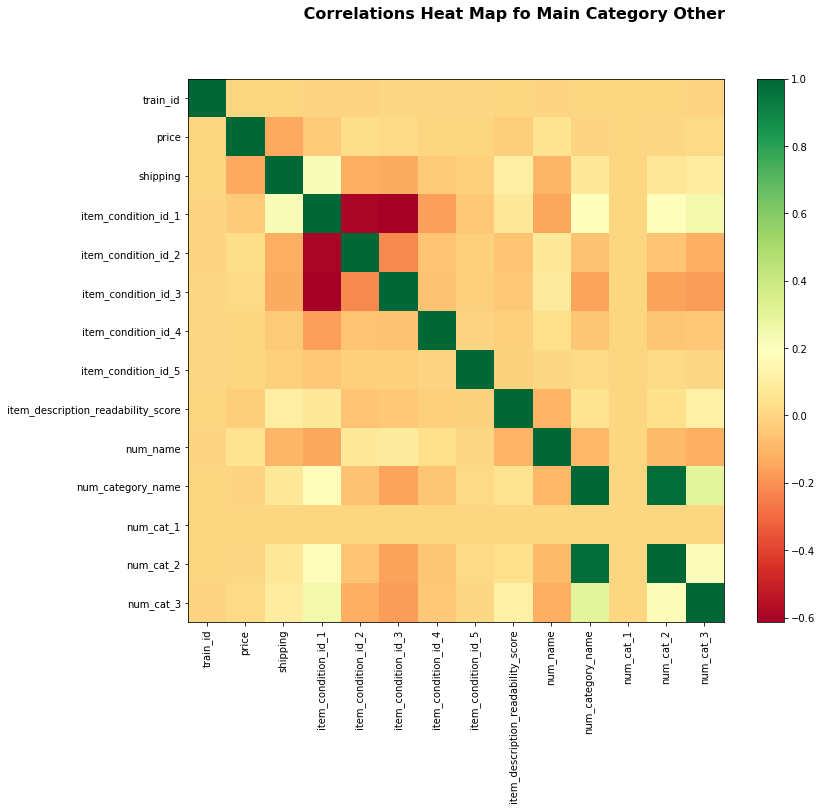

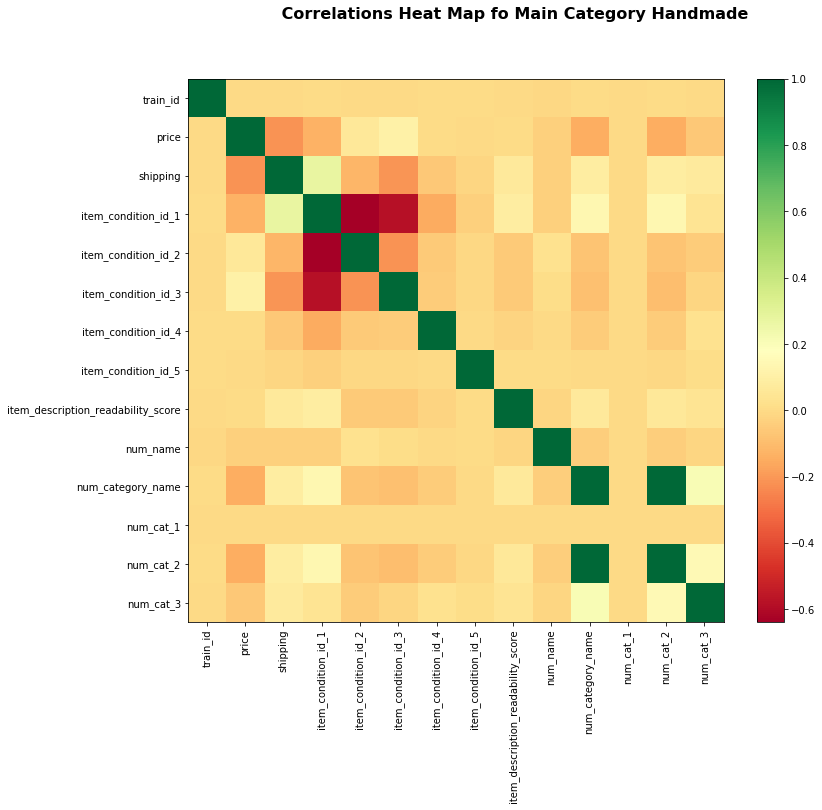

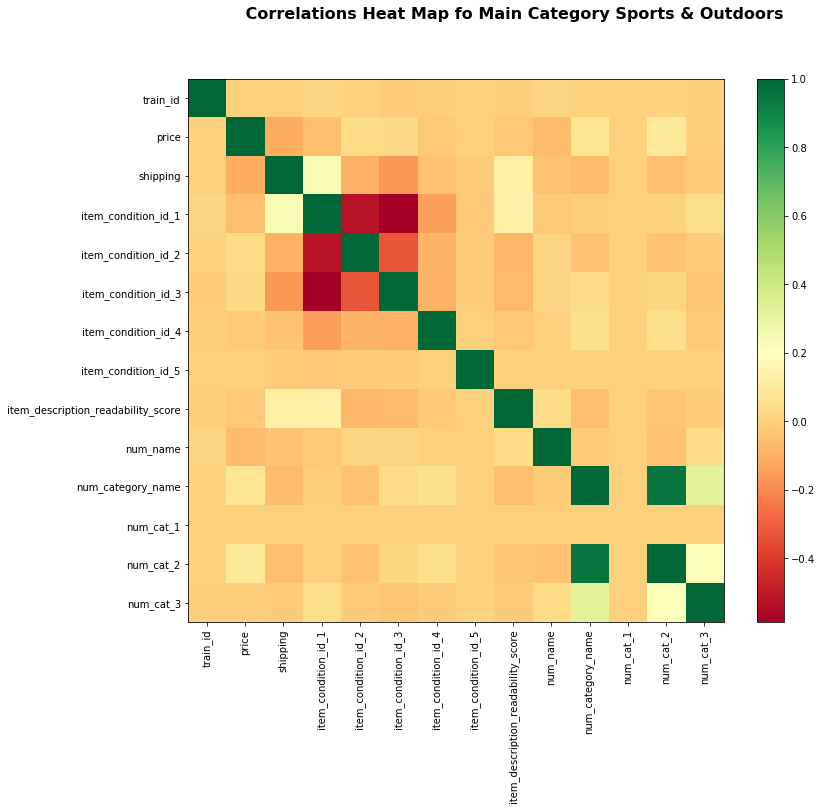

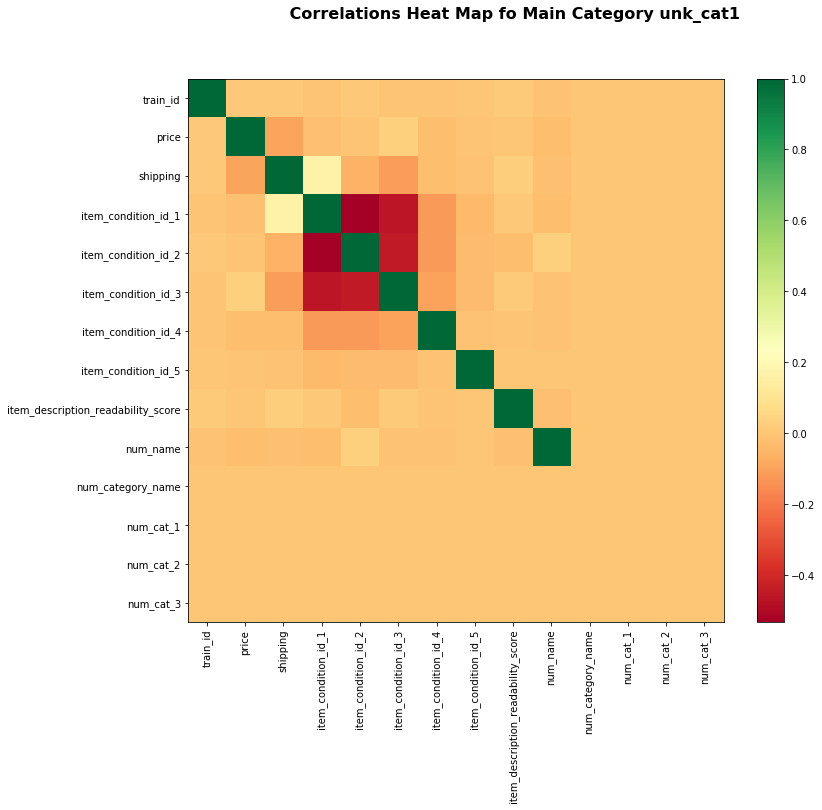

In [0]:
for data in cats:
    gtrain_cat=train_data.loc[train_data['cat_1'] == data]
    corltn=gtrain_cat.corr()
    corltn=corltn.fillna(0)
    plt.figure(figsize=(12, 10))
    plt.imshow(corltn, cmap='RdYlGn', interpolation='none', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(corltn)), corltn.columns, rotation='vertical')
    plt.yticks(range(len(corltn)), corltn.columns);
    plt.suptitle(' Correlations Heat Map fo Main Category '+ data, fontsize=16, fontweight='bold')
    plt.show()

##  3. Data Processing

As per Mercari policy, it does not allow postings below 3 so below that seems to be an error. Removing them helps the models.

In [200]:
# Remove low prices, anything below 3
train_data = train_data.drop(train_data[(train_data.price < 3.0)].index)
train_data.shape

(1481661, 8)

In [201]:
train_data = train_data.drop(train_data[(train_data.price > 2000)].index)
train_data.shape

(1481658, 8)

#### Feature Engineering -


In [202]:
%%time

# calculate readability score from the item_description attribute. The reasoning behind this is that a good product listing will be easy to read an concise. 

ddata = dd.from_pandas(train_data, npartitions=2)

ddata['item_description'] = ddata['item_description'].astype(str)

train_data['item_description_readability_score'] = ddata['item_description'].apply(lambda x: textstat.gunning_fog(x) if x is not '' and x.lower()!='no description yet' else 99, meta=(None, 'float64')).compute(scheduler='multiprocessing')

CPU times: user 22.9 s, sys: 3.32 s, total: 26.2 s
Wall time: 2min 41s


In [203]:
#One-hot-encoding for item_condition_id
train_data = pd.get_dummies(train_data, columns=['item_condition_id'])
train_data.head()

,train_id,name,category_name,brand_name,price,shipping,item_description,item_description_readability_score,item_condition_id_1,item_condition_id_2,item_condition_id_3,item_condition_id_4,item_condition_id_5
0,0,MLB Cincinnati Reds T Shirt Size XL,Men/Tops/T-shirts,NaN,10.0,1,No description yet,99.00,0,0,1,0,0
1,1,Razer BlackWidow Chroma Keyboard,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,8.13,0,0,1,0,0
2,2,AVA-VIV Blouse,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,5.80,1,0,0,0,0
3,3,Leather Horse Statues,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,2.12,1,0,0,0,0
4,4,24K GOLD plated rose,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,18.00,1,0,0,0,0


#### Handling sparse data in brand_name
The brand name data is sparse, missing over many values. 

In [0]:
### concatenating name and brand name and dropping brand column
train_data['name'] = train_data['name'].fillna('') + ' ' + train_data['brand_name'].fillna('')
train_data.drop('brand_name', axis=1, inplace=True)

In [205]:
train_data.isnull().sum()

train_id                                 0
name                                     0
category_name                         6314
price                                    0
shipping                                 0
item_description                         4
item_description_readability_score       0
item_condition_id_1                      0
item_condition_id_2                      0
item_condition_id_3                      0
item_condition_id_4                      0
item_condition_id_5                      0
dtype: int64

 we split the category_name into 3 parts. Our models can get more information this way. 

In [206]:
 %%time
# split category name into 3 parts
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")
train_data['cat_1'], train_data['cat_2'], train_data['cat_3'] = \
zip(*train_data['category_name'].apply(lambda x: split_cat(x)))
train_data['cat_1'], train_data['cat_2'], train_data['cat_3'] = \
zip(*train_data['category_name'].apply(lambda x: split_cat(x)))

CPU times: user 25.8 s, sys: 833 ms, total: 26.6 s
Wall time: 26.6 s


The length of the description i.e. the number of words used, does have some correlation with price. 

The RNN might find this out on it's own, but since a max depth is used to save computations, it does not always know. 

Description length clearly helps the model, name length may be not much. But it doesn't hurt the model's performance , so we will keep it

In [207]:
%%time
# get name and item_description lengths
def wordCount(text):
    try:
        if text == 'No description yet':
            return 0
        else:
            text = text.lower()
            words = [w for w in text.split(" ")]
            return len(words)
    except: 
        return 0
train_data['desc_len'] = train_data['item_description'].apply(lambda x: wordCount(x))
train_data['name_len'] = train_data['name'].apply(lambda x: wordCount(x))
train_data.head()

CPU times: user 7.98 s, sys: 0 ns, total: 7.98 s
Wall time: 7.97 s


### Fill missing data
Note:
replacing 'No description yet' with "missing"  in item_description helps the model a bit by treating it the same as the NA values

In [208]:
%%time

# Filling missing values
# def fill_missing_values(df):
# #     df.category_name.fillna(value="missing", inplace=True)
#     df.item_description.fillna(value="missing", inplace=True)
#     df.item_description.replace('No description yet',"missing", inplace=True)
#     df.cat_1.fillna(value="missing", inplace=True)
#     df.cat_2.fillna(value="missing", inplace=True)
#     df.cat_3.fillna(value="missing", inplace=True)
#     return df

# print("Filling missing data...")
# full_df = fill_missing_values(full_df)
# print(full_df.category_name[1])


def fill_missing_values(df):
    df.category_name.fillna(value="missing", inplace=True)
    df.item_description.fillna(value="unk_description", inplace=True)
    df.item_description.replace('No description yet',"unk_description", inplace=True)
    df.cat_1.fillna(value="unk_cat1", inplace=True)
    df.cat_2.fillna(value="unk_cat2", inplace=True)
    df.cat_3.fillna(value="unk_cat3", inplace=True)
    return df
  
print("Filling missing data...")
train_data = fill_missing_values(train_data)
print(train_data.category_name[1])

Filling missing data...
Electronics/Computers & Tablets/Components & Parts
CPU times: user 859 ms, sys: 0 ns, total: 859 ms
Wall time: 855 ms


### Normalize the price using StandardScaler

In [0]:
# # Scale target variable to log.
# train_data["target"] = np.log1p(train_data.price)

# Standardize target variable price
from sklearn.preprocessing import StandardScaler
scalar=StandardScaler()
scalar.fit(train_data.price.values.reshape(-1,1))
train_data['price'] = scalar.transform(train_data.price.values.reshape(-1,1))
train_data.drop('target', axis=1, inplace=True)

In [213]:
train_data.head()

,train_id,name,category_name,price,shipping,item_description,item_description_readability_score,item_condition_id_1,item_condition_id_2,item_condition_id_3,item_condition_id_4,item_condition_id_5,cat_1,cat_2,cat_3,desc_len,name_len
0,0,MLB Cincinnati Reds T Shirt Size XL,Men/Tops/T-shirts,-0.435170,1,unk_description,99.00,0,0,1,0,0,Men,Tops,T-shirts,0,8
1,1,Razer BlackWidow Chroma Keyboard Razer,Electronics/Computers & Tablets/Components & P...,0.656049,0,This keyboard is in great condition and works ...,8.13,0,0,1,0,0,Electronics,Computers & Tablets,Components & Parts,36,5
2,2,AVA-VIV Blouse Target,Women/Tops & Blouses/Blouse,-0.435170,1,Adorable top with a hint of lace and a key hol...,5.80,1,0,0,0,0,Women,Tops & Blouses,Blouse,29,3
3,3,Leather Horse Statues,Home/Home Décor/Home Décor Accents,0.214365,1,New with tags. Leather horses. Retail for [rm]...,2.12,1,0,0,0,0,Home,Home Décor,Home Décor Accents,32,4
4,4,24K GOLD plated rose,Women/Jewelry/Necklaces,0.448198,0,Complete with certificate of authenticity,18.00,1,0,0,0,0,Women,Jewelry,Necklaces,5,5


### save dataset using pickle

In [0]:
#save the dataset using pickle
train_data.to_pickle(input_folder + 'train_data.pkl') 

In [0]:
# Load saved preprocessed train data and skip previous runs
train_data = pd.read_pickle(input_folder + 'train_data.pkl')

### SPLIT TRAINING INTO TRAIN_DATA AND TEST_DATA

In [10]:
train_data.head()

,train_id,name,category_name,price,shipping,item_description,item_description_readability_score,item_condition_id_1,item_condition_id_2,item_condition_id_3,item_condition_id_4,item_condition_id_5,cat_1,cat_2,cat_3,desc_len,name_len
0,0,MLB Cincinnati Reds T Shirt Size XL,Men/Tops/T-shirts,-0.435170,1,unk_description,99.00,0,0,1,0,0,Men,Tops,T-shirts,0,8
1,1,Razer BlackWidow Chroma Keyboard Razer,Electronics/Computers & Tablets/Components & P...,0.656049,0,This keyboard is in great condition and works ...,8.13,0,0,1,0,0,Electronics,Computers & Tablets,Components & Parts,36,5
2,2,AVA-VIV Blouse Target,Women/Tops & Blouses/Blouse,-0.435170,1,Adorable top with a hint of lace and a key hol...,5.80,1,0,0,0,0,Women,Tops & Blouses,Blouse,29,3
3,3,Leather Horse Statues,Home/Home Décor/Home Décor Accents,0.214365,1,New with tags. Leather horses. Retail for [rm]...,2.12,1,0,0,0,0,Home,Home Décor,Home Décor Accents,32,4
4,4,24K GOLD plated rose,Women/Jewelry/Necklaces,0.448198,0,Complete with certificate of authenticity,18.00,1,0,0,0,0,Women,Jewelry,Necklaces,5,5


In [9]:
#SPLIT TRAINING INTO TRAIN_DATA AND TEST_DATA

train_df, test_df = train_test_split(train_data, random_state=123, train_size=0.99)  #change train_size

# Calculate number of train/dev examples.
n_trains = train_df.shape[0]
n_test = test_df.shape[0]
print("Training on", n_trains, "examples")
print("Testing on", n_test, "examples")

Training on 1466841 examples
Testing on 14817 examples




### Convert Categorical features into continuous features


The columns name: category, cat_1, cat_2, cat_3 and brand_name have categorical values. Categorical values can be converted to One Hot Encoding to feed into a machine learning model. 

In [0]:
%%time

print("Processing categorical data...")

#fit on all the data together (train+ test) using label_encoder
# le = LabelEncoder()
# train_data.category = train_data.category_name
# le.fit(train_data.category_name)
# train_data['category'] = le.transform(train_data.category_name)

# le.fit(train_data.cat_1.astype(str))
# train_data.cat_1 = le.transform(train_data.cat_1)

# le.fit(train_data.cat_2.astype(str))
# train_data.cat_2 = le.transform(train_data.cat_2)

# le.fit(train_data.cat_3.astype(str))
# train_data.cat_3 = le.transform(train_data.cat_3)

# del le


In [0]:
import bisect


def label_encoding(col):
  le = LabelEncoder()
  train_df[col] = train_df[col].astype(str)
  le.fit(train_df[col])

  le_classes = le.classes_.tolist()
  bisect.insort_left(le_classes, '<unknown>')
  le.classes_ = le_classes

  test_df[col] = test_df[col].map(lambda s: '<unknown>' if s not in le.classes_ else s)
  train_df[col] = le.transform(train_df[col])
  test_df[col] = le.transform(test_df[col])
  del le
  return train_df[col], test_df[col]


In [29]:
%%time

train_df['category'] = train_df.category_name
test_df['category'] = test_df.category_name
train_df['category'],test_df['category']  = label_encoding('category')

train_df['cat_1'],test_df['cat_1']  = label_encoding('cat_1')
train_df['cat_2'],test_df['cat_2']  = label_encoding('cat_2')
train_df['cat_3'],test_df['cat_3']  = label_encoding('cat_3')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

CPU times: user 7.47 s, sys: 155 ms, total: 7.62 s
Wall time: 7.61 s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Process text data


In [30]:

%%time

# print("Transforming text data to sequences...")
# raw_text = np.hstack([train_data.item_description.str.lower(), train_data.name.str.lower(), train_data.category_name.str.lower()])

# print("   Fitting tokenizer...")
# tok_raw = Tokenizer()
# tok_raw.fit_on_texts(raw_text)

# print("   Transforming text to sequences...")
# train_data['seq_item_description'] = tok_raw.texts_to_sequences(train_data.item_description.str.lower())
# train_data['seq_name'] = tok_raw.texts_to_sequences(train_data.name.str.lower())

# del tok_raw

print("Transforming text data to sequences...")
raw_text = np.hstack([train_df.item_description.str.lower(), train_df.name.str.lower(), train_df.category_name.str.lower()])

print("   Fitting tokenizer...")
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)

print("   Transforming text to sequences...")
train_df['seq_item_description'] = tok_raw.texts_to_sequences(train_df.item_description.str.lower())
train_df['seq_name'] = tok_raw.texts_to_sequences(train_df.name.str.lower())

test_df['seq_item_description'] = tok_raw.texts_to_sequences(test_df.item_description.str.lower())
test_df['seq_name'] = tok_raw.texts_to_sequences(test_df.name.str.lower())

del tok_raw

Transforming text data to sequences...
   Fitting tokenizer...
   Transforming text to sequences...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

CPU times: user 2min 44s, sys: 1.27 s, total: 2min 45s
Wall time: 2min 45s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [227]:
train_df['seq_name'][:5]

131860          [5276, 10304, 11664, 859, 726]
436335         [1196, 2165, 521, 27, 10, 1747]
1334947    [869, 229, 3889, 206, 349, 79, 229]
585261         [6170, 3, 4211, 872, 366, 1172]
508228          [82, 11306, 3391, 3, 545, 107]
Name: seq_name, dtype: object

In [0]:
train_df.to_pickle(input_folder + 'tok_train_data.pkl')

In [0]:
test_df.to_pickle(input_folder + 'tok_test_data.pkl')

In [0]:
# Load saved preprocessed full_df and skip previous runs
processed_train_data = pd.read_pickle(input_folder + 'full_df.pkl')

### Standard split the train test for validation

In [35]:
#split training examples into train/dev examples.

train_df, dev_df = train_test_split(train_df, random_state=123, train_size=0.99)  #change train_size

# Calculate number of train/dev examples.
n_trains = train_df.shape[0]
n_devs = dev_df.shape[0]
print("Training on", n_trains, "examples")
print("Validating on", n_devs, "examples")

Training on 1437650 examples
Validating on 14522 examples


In [36]:
train_df.head()

,train_id,name,category_name,price,shipping,item_description,item_description_readability_score,item_condition_id_1,item_condition_id_2,item_condition_id_3,item_condition_id_4,item_condition_id_5,cat_1,cat_2,cat_3,desc_len,name_len,category,seq_item_description,seq_name
1156512,1156512,Junior's Large Lace Tank Top Studio Y,"Women/Tops & Blouses/Tank, Cami",-0.565077,1,Measurements are available upon request. No mo...,7.50,0,0,1,0,0,3,81,714,69,7,1261,"[987, 29, 231, 1624, 1324, 21, 2692, 26, 534, ...","[10169, 96, 256, 159, 77, 1986, 2556]"
925416,925416,Scrubs set,Women/Athletic Apparel/Shirts & Tops,-0.409188,0,Both size XS and both SB brand. Has one small ...,2.80,0,0,1,0,0,3,69,621,21,3,1138,"[243, 7, 240, 1, 243, 4403, 16, 76, 51, 59, 87...","[2208, 95]"
1117125,1117125,Vera Bradley Canterberry Magenta Zip C Vera Br...,Women/Women's Accessories/Wallets,-0.175356,1,"Brand new with tag, vera bradley Canterberry M...",5.70,1,0,0,0,0,3,21,810,32,8,1276,"[16, 6, 10, 252, 644, 721, 19297, 2194, 290, 1...","[644, 721, 19297, 2194, 290, 845, 644, 721]"
992189,992189,Binding Of Isaac Afterbirth Switch Nintendo,Electronics/Video Games & Consoles/Games,0.214365,1,Played a couple times. Basically new. Shipped ...,5.84,0,1,0,0,0,1,18,195,11,6,113,"[1451, 5, 528, 169, 1984, 6, 458, 10, 1326, 8,...","[5545, 12, 13969, 87076, 2083, 325]"
110092,110092,Bootcut miss me jeans Miss Me,Women/Jeans/Boot Cut,0.110440,0,Miss me jeans bootcut but on the slimmer side....,4.33,0,1,0,0,0,3,78,556,30,6,1167,"[647, 70, 98, 2663, 49, 14, 3, 6953, 371, 38, ...","[2663, 647, 70, 98, 647, 70]"


In [0]:
# # Concatenate train - dev - test data for easy to handle
# # full_df = pd.concat([train_df, dev_df, test_data])
# full_df = pd.concat([train_df, dev_df])

#### constants

In [37]:
MAX_NAME_SEQ = 10 #17
MAX_ITEM_DESC_SEQ = 75 #269
MAX_CATEGORY_SEQ = 8
MAX_TEXT = np.max([
    np.max(train_df.seq_name.max()),
    np.max(train_df.seq_item_description.max()),
#     np.max(train_df.seq_category.max()),
]) + 100
MAX_CATEGORY = np.max(train_df.category.max()) + 1
MAX_DESC_LEN = int(np.max(train_df.desc_len.max()) + 1)
MAX_NAME_LEN = int(np.max(train_df.name_len.max()) + 1)
MAX_CAT_1 = np.max(train_df.cat_1.max()) + 1
MAX_CAT_2 = np.max(train_df.cat_2.max()) + 1
MAX_CAT_3 = np.max(train_df.cat_3.max()) + 1


print(MAX_CATEGORY)
print(MAX_TEXT)
print(MAX_DESC_LEN)
print(MAX_NAME_LEN)
print(MAX_CAT_1)
print(MAX_CAT_2)
print(MAX_CAT_3)

1288
257847
246
19
11
114
870


In [39]:
## GET DATA FOR RNN

%%time

def get_rnn_data(dataset):
    X = {
        'name': pad_sequences(dataset.seq_name, maxlen=MAX_NAME_SEQ),
        'item_desc': pad_sequences(dataset.seq_item_description, maxlen=MAX_ITEM_DESC_SEQ),
        'category': np.array(dataset.category),
#         'category_name': pad_sequences(dataset.seq_category, maxlen=MAX_CATEGORY_SEQ),
#         'item_condition': np.array(dataset.item_condition_id),
        'shipping': np.array(dataset[["shipping"]]),
        'desc_len': np.array(dataset[["desc_len"]]),
        'name_len': np.array(dataset[["name_len"]]),
        'cat_1': np.array(dataset.cat_1),
        'cat_2': np.array(dataset.cat_2),
        'cat_3': np.array(dataset.cat_3),
        'item_condition_id_1': np.array(dataset.item_condition_id_1),
        'item_condition_id_2': np.array(dataset.item_condition_id_2),
        'item_condition_id_3': np.array(dataset.item_condition_id_3),
        'item_condition_id_4': np.array(dataset.item_condition_id_4),
        'item_condition_id_5': np.array(dataset.item_condition_id_5),
        'item_description_readability_score': np.array(dataset.item_description_readability_score),
    }
    return X

# train = train_df[:n_trains]
# dev = train_data[n_trains:n_trains+n_devs]
# X_train = get_rnn_data(train)
# Y_train = train.price.values.reshape(-1, 1)

# X_dev = get_rnn_data(dev)
# Y_dev = dev.price.values.reshape(-1, 1)


X_train = get_rnn_data(train_df)
Y_train = train_df.price.values.reshape(-1, 1)

X_dev = get_rnn_data(dev_df)
Y_dev = dev_df.price.values.reshape(-1, 1)

X_test = get_rnn_data(test_df)
Y_test = test_df.price.values.reshape(-1, 1)

CPU times: user 14.8 s, sys: 13.7 ms, total: 14.8 s
Wall time: 14.8 s


In [41]:
features = ['seq_name','category','seq_item_description',
            'desc_len','name_len','shipping','cat_1','cat_2','cat_3','item_description_readability_score','item_condition_id_1',
            'item_condition_id_2','item_condition_id_3','item_condition_id_4','item_condition_id_5','price']


train_df[features].head()

,seq_name,category,seq_item_description,desc_len,name_len,shipping,cat_1,cat_2,cat_3,item_description_readability_score,item_condition_id_1,item_condition_id_2,item_condition_id_3,item_condition_id_4,item_condition_id_5,price
1156512,"[10169, 96, 256, 159, 77, 1986, 2556]",1261,"[987, 29, 231, 1624, 1324, 21, 2692, 26, 534, ...",69,7,1,3,81,714,7.50,0,0,1,0,0,-0.565077
925416,"[2208, 95]",1138,"[243, 7, 240, 1, 243, 4403, 16, 76, 51, 59, 87...",21,3,0,3,69,621,2.80,0,0,1,0,0,-0.409188
1117125,"[644, 721, 19297, 2194, 290, 845, 644, 721]",1276,"[16, 6, 10, 252, 644, 721, 19297, 2194, 290, 1...",32,8,1,3,21,810,5.70,1,0,0,0,0,-0.175356
992189,"[5545, 12, 13969, 87076, 2083, 325]",113,"[1451, 5, 528, 169, 1984, 6, 458, 10, 1326, 8,...",11,6,1,1,18,195,5.84,0,1,0,0,0,0.214365
110092,"[2663, 647, 70, 98, 647, 70]",1167,"[647, 70, 98, 2663, 49, 14, 3, 6953, 371, 38, ...",30,6,0,3,78,556,4.33,0,1,0,0,0,0.110440


In [0]:
processed_train_data = train[features].copy  #for purpose of training different model using this data
processed_dev_data  = dev[features].copy

In [0]:


# def root_mean_squared_logarithmic_error(y_true, y_pred):
#     first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
#     second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
#     return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1)+0.0000001)

## 4. Data modeling

### RNN Model

This section will use RNN Model to solve the competition with following steps:

1. Build RNN model
1. Fitting RNN model on training data


### BUILD RNN MODEL

In [42]:
# set seed again in case testing models adjustments by looping next 2 blocks
np.random.seed(123)

def new_rnn_model(lr=0.001, decay=0.0):
  
    # Passing Features from dataset into Input Layer
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
#     category = Input(shape=[1], name="category")

#     item_condition = Input(shape=[1], name="item_condition")
    item_condition_id_1 = Input(shape=[1], name="item_condition_id_1")
    item_condition_id_2 = Input(shape=[1], name="item_condition_id_2")
    item_condition_id_3 = Input(shape=[1], name="item_condition_id_3")
    item_condition_id_4 = Input(shape=[1], name="item_condition_id_4")
    item_condition_id_5 = Input(shape=[1], name="item_condition_id_5")
    item_description_readability_score = Input(shape=[1], name="item_description_readability_score") 
    
    shipping = Input(shape=[X_train["shipping"].shape[1]], name="shipping")
    desc_len = Input(shape=[1], name="desc_len")
    name_len = Input(shape=[1], name="name_len")
    cat_1    = Input(shape=[1], name="cat_1")
    cat_2    = Input(shape=[1], name="cat_2")
    cat_3    = Input(shape=[1], name="cat_3")
    
    
    # Embeddings layers (adjust outputs to help model)
    emb_name = Embedding(MAX_TEXT, 20)(name)
    emb_item_desc = Embedding(MAX_TEXT, 60)(item_desc)
#     emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    
#     emb_category = Embedding(MAX_CATEGORY, 10)(category)
#     emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)
    emb_desc_len = Embedding(MAX_DESC_LEN, 5)(desc_len)
    emb_name_len = Embedding(MAX_NAME_LEN, 5)(name_len)
    emb_cat_1 = Embedding(MAX_CAT_1, 10)(cat_1)
    emb_cat_2 = Embedding(MAX_CAT_2, 10)(cat_2)
    emb_cat_3 = Embedding(MAX_CAT_3, 10)(cat_3)
    

    # rnn layers (GRUs are faster than LSTMs and speed is important here)
    rnn_layer1 = GRU(16) (emb_item_desc)
    rnn_layer2 = GRU(8) (emb_name)
#     rnn_layer3 = GRU(8) (emb_category_name)

    # main layers
    main_l = concatenate([
#         Flatten() (emb_item_condition),
#         , Flatten() (emb_category)
#         ,Flatten() (emb_brand_name)
        Flatten() (emb_desc_len)
        , Flatten() (emb_name_len)
        , Flatten() (emb_cat_1)
        , Flatten() (emb_cat_2)
        , Flatten() (emb_cat_3)
        , rnn_layer1
        , rnn_layer2
#         , rnn_layer3
        , shipping
        , item_condition_id_1
        , item_condition_id_2
        , item_condition_id_3
        , item_condition_id_4
        , item_condition_id_5
        , item_description_readability_score
    ])
    # (incressing the nodes or adding layers does not effect the time quite as much as the rnn layers)
    main_l = Dropout(0.1)(Dense(512,kernel_initializer='normal',activation='relu') (main_l))
    main_l = Dropout(0.1)(Dense(256,kernel_initializer='normal',activation='relu') (main_l))
    main_l = Dropout(0.1)(Dense(128,kernel_initializer='normal',activation='relu') (main_l))
    main_l = Dropout(0.1)(Dense(64,kernel_initializer='normal',activation='relu') (main_l))

    # the output layer.
    output = Dense(1, activation="linear") (main_l)
 
#     model = Model([name, item_desc, item_condition, 
#                    shipping, desc_len, name_len, cat_1, cat_2, cat_3], output)

    model = Model([name, item_desc, item_condition_id_1,item_condition_id_2,item_condition_id_3,item_condition_id_4,item_condition_id_5, 
                   shipping, desc_len, name_len, cat_1, cat_2, cat_3, item_description_readability_score], output)
  
    optimizer = Adam(lr=lr, decay=decay)
    # (mean squared error loss function works as well as custom functions)  
    model.compile(loss = 'mse', optimizer = optimizer)

    return model

model = new_rnn_model()
model.summary()

W0805 06:59:00.896090 140096642451328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 06:59:00.958164 140096642451328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 06:59:00.959954 140096642451328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0805 06:59:01.358946 140096642451328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0805 06:59:01.370795 140096642451328 deprecation_wra

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
desc_len (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
name_len (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
cat_1 (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
cat_2 (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
cat_3 (Inp

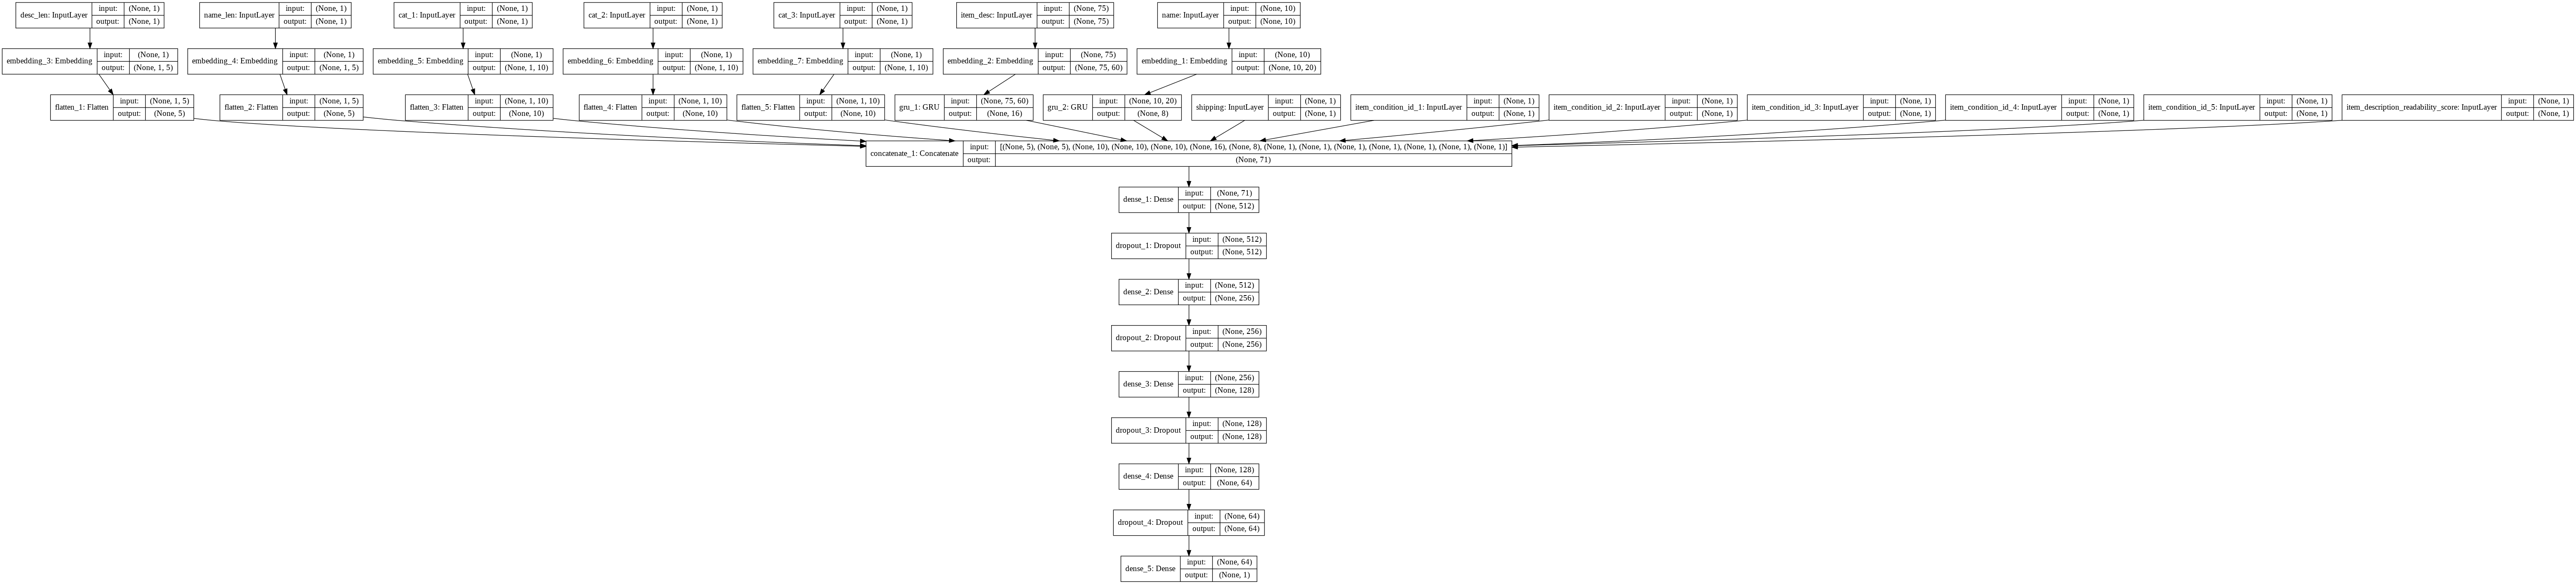

In [43]:
#display model architecture
import pydot_ng as pydot
plot_model(model, show_shapes=True, show_layer_names=True, to_file= input_folder + 'model.png')
from IPython.display import Image
Image(retina=True, filename=input_folder + 'model.png')

In [0]:
del model

### Fitting RNN model to train data

keeping 2 epochs with smaller batches tends to do better than more epochs with larger batches

In [45]:
%%time

# Set hyper parameters for the model.
BATCH_SIZE = 512 * 3
epochs = 2

# Calculate learning rate decay.
exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
steps = int(len(X_train['name']) / BATCH_SIZE) * epochs
lr_init, lr_fin = 0.005, 0.001
lr_decay = exp_decay(lr_init, lr_fin, steps)

# Create model and fit it with training dataset.
rnn_model = new_rnn_model(lr=lr_init, decay=lr_decay)
rnn_model.fit(
        X_train, Y_train, epochs=epochs, batch_size=BATCH_SIZE,
        validation_data=(X_dev, Y_dev), verbose=1,
)

W0805 06:59:14.877166 140096642451328 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1437650 samples, validate on 14522 samples
Epoch 1/2
1437650/1437650 [==============================] - 126s 87us/step - loss: 0.5680 - val_loss: 0.4376
Epoch 2/2
1437650/1437650 [==============================] - 119s 83us/step - loss: 0.4019 - val_loss: 0.4273
CPU times: user 6min 13s, sys: 1min 1s, total: 7min 14s
Wall time: 4min 7s


## 5.  Evaluation

1. Evaluating RNN model
1. Make prediction for test data using RNN model

### RMSL Error Helper Function

In [0]:
# def rmsle(Y, Y_pred):
#     assert Y.shape == Y_pred.shape
#     return np.sqrt(np.mean(np.square(Y_pred - Y )))

def rmsle(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

In [0]:
# def rmsle(y_true, y_pred):
#     first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
#     second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
#     return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1)+0.0000001)

 ### Evaluate RNN model on dev data

In [47]:
%%time

print("Evaluating the model on validation data...")
y_pred = rnn_model.predict(X_dev, batch_size=BATCH_SIZE)
print(" RMSLE Validation error:", rmsle(Y_dev, y_pred))

Evaluating the model on validation data...
 RMSLE Validation error: 0.33624439635582914
CPU times: user 1.05 s, sys: 150 ms, total: 1.2 s
Wall time: 695 ms


Hypertuning parameter to improve validation error

### Make prediction for test data

In [49]:
%%time
Y_test = test_df.price.values.reshape(-1, 1)
print("Evaluating the model on test data...")
y_test_pred = rnn_model.predict(X_test, batch_size=BATCH_SIZE, verbose=1)
print(" RMSLE error:", rmsle(Y_test, y_test_pred))
# rnn_preds = np.expm1(rnn_preds)

Evaluating the model on test data...
14817/14817 [==============================] - 1s 37us/step
 RMSLE error: 0.3681413861051653
CPU times: user 860 ms, sys: 199 ms, total: 1.06 s
Wall time: 547 ms
